## Lab Introduction
Enhance! You've probably seen a movie or TV show where the super spy agents use some unbelievable technique to enhance a pixelated image, or to recover some lossy data. In this lab, you're going to do something similar—this time your objective is to use linear regression to recover or 'fill out' a completely deleted portion of an audio file!

To complete this lab, you will be using The FSDD, Free-Spoken-Digits-Dataset, an audio dataset put together by Zohar Jackson once he noticed there weren't very many cleaned up audio (no dead-space, roughly same length, same bitrate, same samples-per-second rate, etc) audio libraries ready for machine learning.

In [1]:
import numpy as np
import pandas as pd

from sklearn.utils.validation import check_random_state
import scipy.io.wavfile as wavfile

In [2]:
import scipy
scipy.__version__

'1.6.2'

### About Audio

Samples are Observations. Each audio file will is a single sample in our dataset.

Find more information about [Audio Samples here](https://en.wikipedia.org/wiki/Sampling_(signal_processing)).

Each .wav file is actually just a bunch of numeric samples, "sampled" from the analog signal. Sampling is a type of discretization. When we mention 'samples', we mean observations. When we mention 'audio samples', we mean the actually "features" of the audio file.

The goal of this lab is to use multi-target, linear regression to generate by extrapolation, the missing portion of the test audio file.

Each one audio_sample features will be the output of an equation, which is a function of the provided portion of the audio_samples:

    missing_samples = f(provided_samples)

You can experiment with how much of the audio you want to chop off and have the computer generate using the Provided_Portion parameter.

Play with this. This is how much of the audio file will be provided, in percent. The remaining percent of the file will be generated via linear extrapolation.

In [3]:
Provided_Portion = 0.25

## 1. Data Preparation

You have to download the dataset (audio files) from the website: https://github.com/Jakobovski/free-spoken-digit-dataset

Start by creating a regular Python List called `zero`:

In [4]:
# .. your code here ..
zero = []

Loop through the dataset and load up all 50 of the `0_jackson*.wav` files using the `wavfile.read()` method: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html Be careful! `.read()` returns a tuple and you're only interested in the audio data, and not sample_rate at this point. Inside your for loop, simply append the loaded audio data into your Python list `zero`:

In [33]:
sample_rate  = wavfile.read('free-spoken-digit-dataset-master/recordings/0_jackson_28.wav')[0]

In [6]:
from os import listdir
from os.path import join as osjoin
from os.path import dirname


In [7]:
# .. your code here ..
file_path = 'free-spoken-digit-dataset-master/recordings/'
list_audio = listdir('free-spoken-digit-dataset-master/recordings/')
for file in list_audio:
    if file.startswith('0_jackson'):
        audio = wavfile.read(osjoin(file_path, file))
        zero.append(audio[1])

In [8]:
len(zero)

50

In [14]:
zero

[array([-369, -431, -475, ...,  301,  324,  304], dtype=int16),
 array([-311,  -91, -140, ...,  378,  357,  333], dtype=int16),
 array([-314, -303, -332, ..., -355, -343, -322], dtype=int16),
 array([347, 351, 462, ..., 365, 338, 302], dtype=int16),
 array([-336,  160,   65, ..., -315, -343, -319], dtype=int16),
 array([ 354,  442,  610, ..., -312, -336, -333], dtype=int16),
 array([ 397,  531,  638, ..., -357, -386, -353], dtype=int16),
 array([ 382,  459,  530, ..., -254, -301, -309], dtype=int16),
 array([-393,   54,  -71, ...,  319,  340,  313], dtype=int16),
 array([-311, -363, -318, ..., -239, -305, -304], dtype=int16),
 array([-316, -336, -342, ..., -442, -424, -310], dtype=int16),
 array([ 335,  392,  481, ..., -302, -314, -304], dtype=int16),
 array([-361, -226, -238, ..., -286, -311, -343], dtype=int16),
 array([-309, -323, -333, ..., -301, -300, -304], dtype=int16),
 array([ 305,  305,  294, ..., -379, -342, -300], dtype=int16),
 array([ 342,  452,  546, ..., -356, -353, -33

Just for a second, convert zero into a DataFrame. When you do so, set the `dtype` to `np.int16`, since the input audio files are 16 bits per sample. If you don't know how to do this, read up on the docs here: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

Since these audio clips are unfortunately not length-normalized, we're going to have to just hard chop them to all be the same length. Since Pandas would have inserted NANs at any spot to make zero a  perfectly rectangular [n_observed_samples, n_audio_samples] array, do a `dropna` on the Y axis here. Then, convert one back into an NDArray using `yourarrayname.values`:

In [10]:
# .. your code here ..
df = pd.DataFrame(zero, dtype = 'int16')
df.dropna(axis = 1, inplace = True)
df.shape

(50, 4087)

In [11]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086
0,-369,-431,-475,-543,-571,-557,-528,-455,-394,-305,...,2475,2500,2331,1786,1057,358,158,-108,-402,-884
1,-311,-91,-140,-182,-271,-68,-235,-359,-129,-198,...,-122,-207,-266,-276,-316,-359,-396,-422,-462,-460
2,-314,-303,-332,-376,-344,-344,-334,-295,-243,-224,...,-2084,-1223,-226,960,2267,3264,3553,3418,2640,1202
3,347,351,462,451,499,509,469,534,362,464,...,1163,1075,831,269,-419,-1247,-2099,-2615,-2777,-2561
4,-336,160,65,-161,-23,61,39,-332,348,-198,...,105,98,118,99,64,-73,-181,-315,-343,-319


In [12]:
zero = df.to_numpy()

It's important to know how (many audio_samples samples) long the data is now.

`zero` is currently shaped like `[n_samples, n_audio_samples]`, so get the `n_audio_samples` count and store it in a variable called `n_audio_samples`:

In [13]:
zero.shape

(50, 4087)

In [14]:
# .. your code here ..
n_audio_samples = zero.shape[1]

In [15]:
n_audio_samples

4087

## 2. Training the Model

Create your linear regression model here and store it in a variable called `model`. Don't actually train or do anything else with it yet:

In [16]:
# .. your code here ..
from sklearn.linear_model import LinearRegression
model = LinearRegression()

There are 50 takes of each clip. You want to pull out just one of them, randomly, and that one will NOT be used in the training of your model. In other words, the one file we'll be testing / scoring on will be an unseen sample, independent to the rest of your training set:

In [17]:
check_random_state(7)

RandomState(MT19937) at 0x1B5D7B63840

In [18]:
# Leave this line alone until you've submitted your lab:
rng = check_random_state(7)

random_idx = rng.randint(zero.shape[0])
test  = zero[random_idx]
train = np.delete(zero, [random_idx], axis=0)

Print out the shape of `train`, and the shape of `test`.

`train` will be shaped: `[n_samples, n_audio_samples]`, where `n_audio_samples` are the 'features' of the audio file 

`test` will be shaped `[n_audio_features]`, since it is a single sample (audio file, e.g. observation).

In [30]:
# .. your code here ..
print(train.shape)
print(test.shape)

(49, 4087)
(4087,)


The test data will have two parts, `X_test` and `y_test`.

`X_test` is going to be the first portion of the test audio file, which we will be providing the computer as input. 

`y_test`, the "label" if you will, is going to be the remaining portion of the audio file. Like such, the computer will use linear regression to derive the missing portion of the sound file based off of the training data its received!

Let's save the original `test` clip, the one you're about to delete half of, to the current directory so that you can compare it to the 'patched' clip once you've generated it. You should have already got the `sample_rate` when you were loading up the .wav files:

In [34]:
wavfile.write('Original Test Clip.wav', sample_rate, test)

Prepare the TEST data by creating a slice called `X_test`. It should have `Provided_Portion` * `n_audio_samples` audio sample features, taken from your test audio file, currently stored in variable `test`. In other words, grab the FIRST `Provided_Portion` * `n_audio_samples` audio features from `test` and store it in `X_test`. This should be accomplished using indexing:

In [38]:
n_audio_samples

4087

In [40]:
test

array([-417,  152,  168, ...,  638,  463,  332], dtype=int16)

In [43]:
# .. your code here ..
X_test = test[:int(Provided_Portion * n_audio_samples)]

If the first `Provided_Portion` * `n_audio_samples` features were stored in `X_test`, then we need to also grab the _remaining_ audio features and store them in `y_test`. With the remaining features stored in there, we will be able to R^2 "score" how well our algorithm did in completing the sound file.

In [44]:
# .. your code here ..
y_test = test[int(Provided_Portion * n_audio_samples):]

In [45]:
X_test.shape

(1021,)

In [46]:
y_test.shape

(3066,)

Duplicate the same process for `X_train`, `y_train`. The only differences being:

1. Your will be getting your audio data from `train` instead of from `test`
2. Remember the shape of `train` that you printed out earlier? You want to do this slicing but for ALL samples (observations). For each observation, you want to slice the first `Provided_Portion` * `n_audio_samples` audio features into `X_train`, and the remaining go into `y_train`. All of this should be doable using regular indexing in two lines of code:

In [48]:
# .. your code here ..
X_train = train[:, :int(Provided_Portion * n_audio_samples)]
y_train = train[:, int(Provided_Portion * n_audio_samples):]

SciKit-Learn gets 'angry' if you don't supply your training data in the form of a 2D dataframe shaped like `[n_samples, n_features]`.

So if you only have one SAMPLE, such as is our case with `X_test`, and `y_test`, then by calling `.reshape(1, -1)`, you can turn `[n_features]` into `[1, n_features]` in order to appease SciKit-Learn.

On the other hand, if you only have one FEATURE, you can alternatively call `.reshape(-1, 1)` on your data to turn `[n_samples]` into `[n_samples, 1]`.

Reshape X_test and y_test as [1, n_features]:

In [53]:
X_test.reshape(..., 1)

TypeError: 'ellipsis' object cannot be interpreted as an integer

In [54]:
# .. your code here ..
X_test = X_test.reshape(1, -1)
y_test = y_test.reshape(1, -1)

Fit your model using your training data and label:

In [55]:
# .. your code here ..
model.fit(X_train, y_train)

LinearRegression()

## 3. Model Evaluation

Use your model to predict the `label` of `X_test`. Store the resulting prediction in a variable called `y_test_prediction`:

In [56]:
# .. your code here ..
y_test_prediction = model.predict(X_test)

SciKit-Learn will use float64 to generate your predictions so let's take those values back to int16, which is what our .wav files expect:

In [59]:
y_test_prediction

array([[-4926, -6274, -6148, ...,  2963,   605,   317]], dtype=int16)

In [58]:
y_test_prediction = y_test_prediction.astype(dtype=np.int16)

Score how well your prediction would do for some good laughs, by passing in your test data and test label `y_test`:

In [123]:
y_test = y_test.astype('int64')
y_test_prediction = y_test_prediction.astype('int64')

In [124]:
# .. your code here ..

score = 1 - ((y_test - y_test_prediction)**2).sum()/((y_test - y_test.mean())**2).sum()

In [127]:
((y_test - y_test_prediction)**2).sum()

285830374772

In [108]:
np.power(y_test.reshape(-1,), 2)

array([-25536, -19612,  21993, ...,  13828,  17761, -20848], dtype=int16)

In [104]:
y_test**2

array([[-25536, -19612,  21993, ...,  13828,  17761, -20848]], dtype=int16)

In [101]:
y_test - y_test_prediction

array([[-3066, -2376, -2857, ..., -2325,  -142,    15]], dtype=int16)

In [102]:
np.power((y_test - y_test_prediction), 2)

array([[ 28708,   9280, -29551, ...,  31673,  20164,    225]], dtype=int16)

In [125]:
print("Extrapolation R^2 Score: ", score)

Extrapolation R^2 Score:  -8.901095022949223


Let's take the first `Provided_Portion` portion of the test clip, the part you fed into your linear regression model. Then, stitch that together with the 'abomination' the predictor model generated for you and then save the completed audio clip:

In [65]:
completed_clip = np.hstack((X_test, y_test_prediction))
wavfile.write('Extrapolated Clip.wav', sample_rate, completed_clip[0])

In [72]:
import matplotlib.pyplot as plt

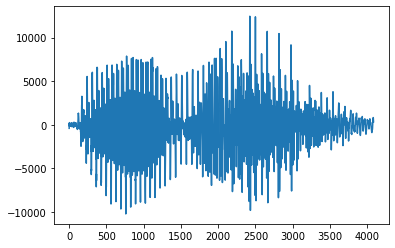

In [92]:
plt.plot(test)

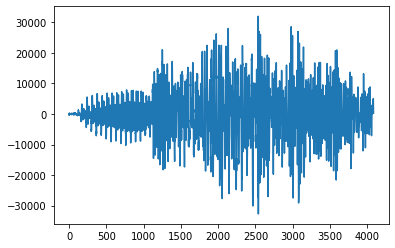

In [87]:
plt.plot(completed_clip.reshape(4087,))